# Preliminary

## Import library & GPU setup

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Allow memory growth to avoid consuming all GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is being used")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


GPU is being used


## Load Dataset

In [2]:
%pip install tensorflow


     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/385.0 MB 744.7 kB/s eta 0:08:37
   ---------------------------------------- 0.1/385.0 MB 744.7 kB/s eta 0:08:37
   ---------------------------------------- 0.2/385.0 MB 903.5 kB/s eta 0:07:06
   ---------------------------------------- 0.2/385.0 MB 903.5 kB/s eta 0:07:06
   ---------------------------------------- 0.3/385.0 MB 850.6 kB/s eta 0:07:33
   ---------------------------------------- 0.3/385.0 MB 850.6 kB/s eta 0:07:33
   ---------------------------------------- 0.3/385.0 MB 850.6 kB/s eta 0:07:33
   ---------------------------------------- 0.3/385.0 MB 654.1 kB/s eta 0:

In [8]:
import tensorflow as tf
from keras import layers, models

# Set a random seed for reproducibility
tf.random.set_seed(42)

# Load the datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\CMU\Chest_xray\Chest_xray\2D\train',
    batch_size=32,
    image_size=(128, 128),  # Resize images if needed
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\CMU\Chest_xray\Chest_xray\2D\test',
    batch_size=32,
    image_size=(128, 128)  # Resize images if needed
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\CMU\Chest_xray\Chest_xray\2D\val',
    batch_size=32,
    image_size=(128, 128)  # Resize images if needed
)


Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [4]:
from collections import Counter

# Initialize a Counter to count the number of images per class
class_counts = Counter()

# Iterate over the dataset and count the labels
for images, labels in train_dataset:
    class_counts.update(labels.numpy())

# Get class names from the dataset
class_names = train_dataset.class_names

# Print the count of images per class
for class_index, class_count in class_counts.items():
    class_name = class_names[class_index]
    print(f"Class '{class_name}' has {class_count} images.")

Class 'PNEUMONIA' has 3875 images.
Class 'NORMAL' has 1341 images.


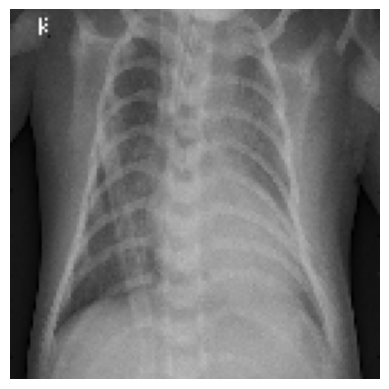

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Get the first batch of images and labels
for images, labels in train_dataset.take(1):
    # Extract the first image
    first_image = images[0].numpy().astype("uint8")

    # Display the image
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()
    break


## Model Construction

In [6]:
# Define a simple CNN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Use softmax if you have more than two classes
])
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use sparse_categorical_crossentropy for more than two classes
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

## Model training 

In [8]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/3
163/163 [==============================] - 15s 66ms/step - loss: 0.2651 - accuracy: 0.8806 - val_loss: 0.4286 - val_accuracy: 0.7500
Epoch 2/3
163/163 [==============================] - 10s 60ms/step - loss: 0.0983 - accuracy: 0.9617 - val_loss: 0.1023 - val_accuracy: 1.0000
Epoch 3/3
20/20 [==============================] - 1s 43ms/step - loss: 1.0472 - accuracy: 0.7612
Test accuracy: 0.7612179517745972


## Release memory

In [9]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()